In [2]:
import geopandas as gpd
import requests
from shapely.geometry import Point, LineString, MultiPoint, MultiLineString
from shapely.ops import linemerge, split
import numpy as np

In [3]:
filepath = "../data/map.geo.admin.ch_GPX_20250522075309.gpx"

In [4]:
def get_height(easting: float, 
               northing: float, 
               max_retries: int = 3):
    """
    Fragt die Höhe für einen Punkt (in LV95) bei der Swisstopo-API ab
    und gibt sie als float zurück.
    """
    HEIGHT_URL = "https://api3.geo.admin.ch/rest/services/height"
    params = {"easting": easting, "northing": northing}
    for attempt in range(max_retries):
        r = requests.get(HEIGHT_URL, params=params, timeout=5)
        if r.status_code == 200:
            return r.json()["height"]
    r.raise_for_status()


In [5]:
def to_3d_Point(pt: Point):
    z = get_height(pt.x, pt.y)
    return Point(pt.x, pt.y, z) 

In [6]:
def densify(linestring: LineString, 
            interval: float = 100.0):
    
    total_len = linestring.length
    orig_dists = [linestring.project(Point(x, y)) for x, y in linestring.coords]
    regular_dists = list(np.arange(0, total_len, interval))
    regular_dists.append(total_len)
    all_dists = sorted(set(orig_dists + regular_dists))
    pts = [linestring.interpolate(d) for d in all_dists]

    return LineString([(p.x, p.y) for p in pts])

In [7]:

## Erstellung Waypoints GeoDataFrame
gdf_waypoints = gpd.read_file(filepath, layer="waypoints", driver="GPX")
gdf_waypoints['id'] = range(1, len(gdf_waypoints)+1)
gdf_waypoints = gdf_waypoints.set_crs(epsg=4326, allow_override=True).to_crs(epsg=2056)
gdf_waypoints["geometry"] = gdf_waypoints.geometry.apply(to_3d_Point)
gdf_waypoints = gdf_waypoints[["id","name", "geometry"]]

## Erstellung des MultiLine Tracks GeoDataFrame
gdf_routes = gpd.read_file(filepath, layer="routes", driver="GPX")
gdf_routes = gdf_routes.set_crs(epsg=4326, allow_override=True).to_crs(epsg=2056)
gdf_routes = gdf_routes[["geometry"]]
mls = MultiLineString(gdf_routes.geometry.tolist())
merged  = linemerge(mls)


## Aufteilen der Linie in Segmente gemäss den Waypoints
points = gdf_waypoints.geometry.to_list()
projected = [merged.interpolate(merged.project(pt)) for pt in points]
mp = MultiPoint(projected)
pieces = split(merged, mp)
segments = list(pieces.geoms)
gdf_lines = gpd.GeoDataFrame(
    {'geometry': segments}
)

## Weitere Stützpunkte den Linestrings hinzufügen
gdf_lines['geometry'] = gdf_lines.geometry.apply(lambda ln: densify(ln, interval=100.0))

In [8]:
gdf_waypoints

,id,name,geometry
0,1,Startpunkt,POINT Z (2615292.286 1264887.924 279.7)
1,2,Ende,POINT Z (2621085.137 1261293.638 310.5)
2,3,Hintere Burg,POINT Z (2616488.117 1263427.786 431.5)
3,4,Mittlere Burg,POINT Z (2616298.894 1263194.66 476.4)
4,5,Lecker Weinchen,POINT Z (2617072.551 1262557.063 411)
5,6,Schauenburg,POINT Z (2618037.624 1261126.735 568.2)


In [9]:
gdf_lines

,geometry
0,"LINESTRING (2615292.286 1264887.924, 2615373.6..."
1,"LINESTRING (2616488.117 1263427.786, 2616489.0..."
2,"LINESTRING (2616298.894 1263194.66, 2616310.18..."
3,"LINESTRING (2617072.551 1262557.063, 2617169.8..."
4,"LINESTRING (2618037.624 1261126.735, 2618074.5..."


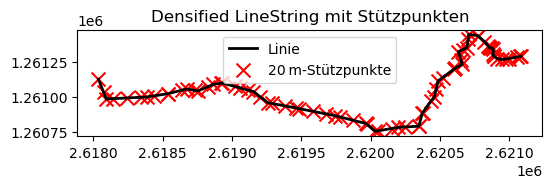

In [12]:
import matplotlib.pyplot as plt

# 1) Deinen (bereits densified) LineString holen
dense_line0 = gdf_lines.geometry.iloc[4]

# 2) Koordinaten extrahieren
# Variante a: mit coords
coords = list(dense_line0.coords)     # [(x1,y1), (x2,y2), ...]
x_pts, y_pts = zip(*coords)

# Variante b: mit .xy
# x_pts, y_pts = dense_line0.xy

# 3) Plotten
fig, ax = plt.subplots(figsize=(6,8))
#    erst die Linie
x_line, y_line = dense_line0.xy
ax.plot(x_line, y_line, '-', lw=2, color='black', label='Linie')
#    dann die Punkte
ax.scatter(x_pts, y_pts, s=100, c='red', marker='x', label='20 m-Stützpunkte')

ax.set_aspect('equal')
ax.set_title("Densified LineString mit Stützpunkten")
ax.legend()
plt.show()
